# API'ing Eurostat and building maps with eurostatapiclient

Eurostat's API is a bit complicated to use. You can make use of their query builder to understand the structure: <br>
Query Builder: https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder<br>
But fortunately there is a Python wrapper: eurostatapiclient

In [130]:
%matplotlib inline  

If dependencies are not managed via pipenv (https://docs.pipenv.org/en/latest/basics/): 

In [142]:
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import json
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn

#And now: The Eurostat API wrapper - find it here: https://github.com/opus-42/eurostat-api-client
from eurostatapiclient import EurostatAPIClient

In [144]:
VERSION = 'v2.1'

# only json supported
FORMAT = 'json'

# Specify language : en, fr, de
LANGUAGE = 'de'

# initializing
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [145]:
# get the dataset by using Eurostat's ids
# e.g. from here: https://ec.europa.eu/eurostat/web/regions/data/database

id = 'tgs00101'

# You can define some filters 

params = {
    #'geo': 'DE',
    'time': '2017',
    #'sex' : 'F'
}

time = params['time']

filtered_dataset = client.get_dataset(id, params=params)


filtered_dataframe = filtered_dataset.to_dataframe()

In [146]:
# extract the title of the dataset
title = filtered_dataset.label
print(filtered_dataset.label)

Lebenserwartung bei der Geburt nach Geschlecht und NUTS-2-Region 


In [147]:
# take a quick look at the dataframe
# Column "geo" should show you the NUTS2 regional code
filtered_dataframe.head()

,values,unit,age,sex,geo,time
0,83.9,YR,Y_LT1,F,AT11,2017
1,83.7,YR,Y_LT1,F,AT12,2017
2,82.9,YR,Y_LT1,F,AT13,2017
3,84.3,YR,Y_LT1,F,AT21,2017
4,84.2,YR,Y_LT1,F,AT22,2017


In [148]:
filtered_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 6 columns):
values    981 non-null float64
unit      1101 non-null object
age       1101 non-null object
sex       1101 non-null object
geo       1101 non-null object
time      1101 non-null object
dtypes: float64(1), object(5)
memory usage: 51.7+ KB


In [149]:
# finding max value
filtered_dataframe.loc[filtered_dataframe['values'].idxmax()]

values     87.5
unit         YR
age       Y_LT1
sex           F
geo        ES30
time       2017
Name: 106, dtype: object

# GeoJSON

Ok, let's start with the mapping

In [150]:
# Get the NUTS2 GeoJSON here: https://github.com/eurostat/Nuts2json
map_df = gpd.read_file("https://raw.githubusercontent.com/eurostat/Nuts2json/gh-pages/2016/3035/20M/2.json")


In [151]:
# Rename the column "id" to "geo"
map_df['geo'] = map_df['id'] 

In [152]:
map_df.head()

,id,na,geometry,geo
0,CY00,Κύπρος,"POLYGON ((6342658.765438272 1629638.12840642, ...",CY00
1,CZ01,Praha,"POLYGON ((4626513.550677534 3007203.215160758,...",CZ01
2,CZ02,Střední Čechy,"POLYGON ((4685673.461173058 3058448.376918846,...",CZ02
3,CZ03,Jihozápad,"POLYGON ((4564814.588229411 3003094.953247663,...",CZ03
4,CZ04,Severozápad,"POLYGON ((4638954.905245262 3053475.217760888,...",CZ04


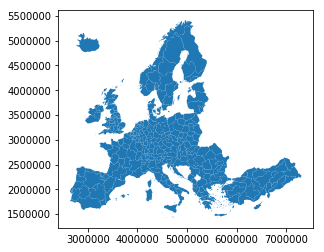

In [153]:
# Quick plot of the GeoJSON
map_df.plot()

In [154]:
# Map the corresponding NUTS2 columns from Eurostat's dataset and the GeoJSON and merge the two dataframes

merged = map_df.merge(filtered_dataframe, left_on='geo', right_on='geo')

merged.head(10)

,id,na,geometry,geo,values,unit,age,sex,time
0,CY00,Κύπρος,"POLYGON ((6342658.765438272 1629638.12840642, ...",CY00,84.2,YR,Y_LT1,F,2017
1,CY00,Κύπρος,"POLYGON ((6342658.765438272 1629638.12840642, ...",CY00,80.2,YR,Y_LT1,M,2017
2,CY00,Κύπρος,"POLYGON ((6342658.765438272 1629638.12840642, ...",CY00,82.2,YR,Y_LT1,T,2017
3,CZ01,Praha,"POLYGON ((4626513.550677534 3007203.215160758,...",CZ01,83.1,YR,Y_LT1,F,2017
4,CZ01,Praha,"POLYGON ((4626513.550677534 3007203.215160758,...",CZ01,78.4,YR,Y_LT1,M,2017
5,CZ01,Praha,"POLYGON ((4626513.550677534 3007203.215160758,...",CZ01,80.8,YR,Y_LT1,T,2017
6,CZ02,Střední Čechy,"POLYGON ((4685673.461173058 3058448.376918846,...",CZ02,81.8,YR,Y_LT1,F,2017
7,CZ02,Střední Čechy,"POLYGON ((4685673.461173058 3058448.376918846,...",CZ02,76.3,YR,Y_LT1,M,2017
8,CZ02,Střední Čechy,"POLYGON ((4685673.461173058 3058448.376918846,...",CZ02,79.1,YR,Y_LT1,T,2017
9,CZ03,Jihozápad,"POLYGON ((4564814.588229411 3003094.953247663,...",CZ03,82.1,YR,Y_LT1,F,2017


In [155]:
# set a variable that will call whatever column we want to visualise on the map

variable = 'values'

# set the range for the Choropleth colours

vmax = filtered_dataframe.loc[filtered_dataframe['values'].idxmax()]['values']
vmin = filtered_dataframe.loc[filtered_dataframe['values'].idxmin()]['values']

# Check
print(vmax, vmin)

# Optional: You could set vmin = 0
# vmin = 0

87.5 69.8


In [156]:
# headline / title

headline = "Growing old in southern Europe"

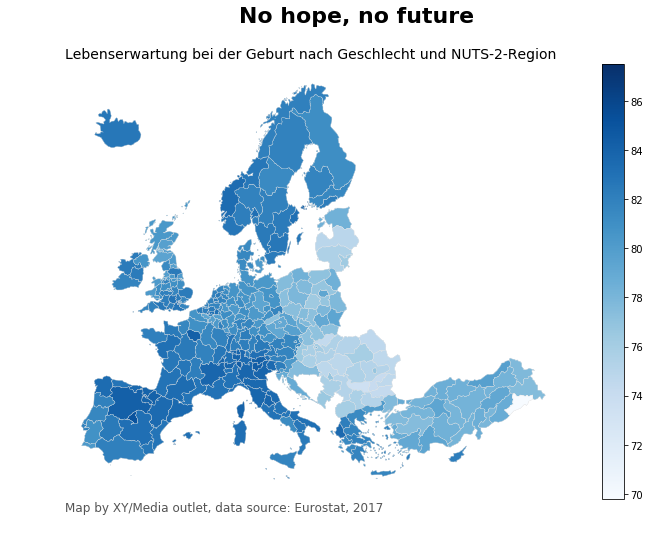

In [158]:
fig, ax = plt.subplots(1, figsize=(12, 8))

merged.plot(column='values', cmap='Blues', k=5, linewidth=0.3, ax=ax, edgecolor='0.9', vmin=vmin, vmax=vmax)  

# remove the Axis
ax.axis('off')

# Add a headline 
fig.suptitle(headline, fontsize=22, fontweight='bold')

# Use the Axis title for subtitle - e.g. the extracted title from above
ax.set_title(title, fontdict={'fontsize': '14', 'fontweight' : '3'})

annotation = "Map by XY/Media outlet, data source: Eurostat, " + time


# Add the Source
ax.annotate(annotation,xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm)


In [40]:
fig.savefig("map_export.png", dpi=300)
fig.savefig("map_export_illustrator.svg", dpi=300)